## Fitting the mapped data (with inclusion of the features) through LinearSVC

In [1]:
# Load packages
import pandas as pd
import numpy as np
import cv2 as cv

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
import time

## Linear SVC on UMAP Data 
### Data includes Gray + HOG + BRISK

**map validation data**

In [6]:
# Load new data
img_df = pd.read_csv('gray_small_test_set.csv')
img_df.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel1190,pixel1191,pixel1192,pixel1193,pixel1194,pixel1195,pixel1196,pixel1197,pixel1198,pixel1199
0,0,255,255,255,255,254,250,217,214,201,...,255,255,255,255,255,255,255,255,255,255
1,1,255,255,255,255,255,255,255,255,254,...,248,253,253,253,255,255,255,255,255,255
2,0,255,255,255,255,253,253,202,201,202,...,254,254,255,254,255,255,255,255,255,255
3,3,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,1,255,255,255,255,255,255,255,255,252,...,250,250,252,254,255,255,255,255,255,255


**Concatenate Data**

In [7]:
hog_df = pd.read_csv('hog_fd_test.csv')
brisk_df = pd.read_csv('brisk_test.csv')

In [8]:
test_data = pd.concat([img_df, hog_df.iloc[:,1:], brisk_df.iloc[:,1:]], axis=1)

**map validation data with features**

In [12]:
import joblib
percent=100
start_time = time.time()
# Load the saved model
umap_model = joblib.load('umap_model_gray_small_hog_brisk.pkl')

# Transform new data
#slicing is to remove label in column 0
embedding = umap_model.transform(test_data.iloc[:,1:])
print('percent complete: ',percent, end =" - %s seconds -\n" % \
              (time.time() - start_time), flush=False)



percent complete:  100 - 1.6300685405731201 seconds -


In [10]:
embedding

array([[ 8.95238   , -5.223087  ],
       [ 5.191209  , -0.69167835],
       [ 7.1817408 , -5.467498  ],
       ...,
       [-0.48632234, -8.051082  ],
       [-0.02243627, -2.788068  ],
       [ 8.412993  , -6.238215  ]], dtype=float32)

**export mapped validation data to csv for later use**

In [11]:
test_data.head(2)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,brisk1190,brisk1191,brisk1192,brisk1193,brisk1194,brisk1195,brisk1196,brisk1197,brisk1198,brisk1199
0,0,255,255,255,255,254,250,217,214,201,...,0,0,0,0,0,0,0,0,0,0
1,1,255,255,255,255,255,255,255,255,254,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#
target = test_data['label']
target = target[:, np.newaxis]

# Concatenate along the second axis
emb_target = np.concatenate((target, embedding), axis=1)

column_names = ['label','embedding x', 'embedding y']
embedding_df = pd.DataFrame( emb_target, columns=column_names)
#embedding_df.head()

embedding_df.to_csv('umap_test_gray_small_hog_brisk.csv', index=False, header=True)  

C:\Users\edgomr\AppData\Local\Temp\ipykernel_1452\1053442049.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  target = target[:, np.newaxis]


**we use the mapped train data to do a linear fit with SVC**

In [16]:
#previously mapped by UMAP
train_umap = pd.read_csv('umap_train_gray_small_hog_brisk.csv')

In [18]:
test_umap = pd.read_csv('umap_test_gray_small_hog_brisk.csv')

In [19]:
train_umap.head(2)

,label,embedding x,embedding y
0,0.0,9.754247,-6.922257
1,2.0,-1.047488,-1.155771


In [20]:
test_umap.head(2)

,label,embedding x,embedding y
0,0.0,8.952380,-5.223087
1,1.0,5.191209,-0.691678


**ready to create training data for LinearSVC**

In [24]:
#train_df.iloc[:, 1:].values.astype(np.float32)
x_train_u = train_umap.iloc[:, 1:].values.astype(np.float32)
y_train_u =train_umap['label'].values


In [25]:
x_test_u = test_umap.iloc[:, 1:].values.astype(np.float32)
y_test_u =test_umap['label'].values

**immediate output**

In [26]:
# Classification with a linear SVM
svc = LinearSVC(dual=False, random_state=123)
params_grid = {"C": [10 ** k for k in range(-3, 4)]}
clf_umap = GridSearchCV(svc, params_grid)
clf_umap.fit(x_train_u, y_train_u)


GridSearchCV(estimator=LinearSVC(dual=False, random_state=123),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

**validation data**

In [27]:
print("Accuracy on the test set with gray data: {:.3f}".format(clf_umap.score(x_test_u, y_test_u)))

Accuracy on the test set with gray data: 0.948


**can save the fitted model for later use**

In [28]:
import pickle

# Save to file
with open('umap_gray_small_hog_brisk.pkl', 'wb') as f:
    pickle.dump(clf_umap, f)


In [29]:
# Load from file
with open('umap_gray_small_hog_brisk.pkl', 'rb') as f:
    clf_gumap_loaded = pickle.load(f)

In [31]:
decipher_key = {
    0:"Pants",
    1:"Tshirts",
    2:"Watches",
    3:"Casual Shoes"
 
}

In [32]:
#define list, x data test list from umap
x_tlistu =[]
y_tlistu = []
tlabelu =[]
for i in range(4):
    indices = np.where(y_test_u == i)[0]
    y_tlistu.append(y_test_u[indices])
    x_tlistu.append(x_test_u[indices])
    tlabelu.append(decipher_key[i])
    
y_tlistu[0].shape, y_tlistu[0][0:3]

((239,), array([0., 0., 0.]))

**Accuracy on Validation data:**

In [33]:
for i in range(4):
    print("Accuracy on the",tlabelu[i]," test set with grayscale image: {:.3f}".\
          format(clf_gumap_loaded.score(x_tlistu[i], y_tlistu[i])))

Accuracy on the Pants  test set with grayscale image: 0.921
Accuracy on the Tshirts  test set with grayscale image: 0.890
Accuracy on the Watches  test set with grayscale image: 0.976
Accuracy on the Casual Shoes  test set with grayscale image: 1.000


In [34]:
from sklearn.metrics import confusion_matrix
#x_tlist[i]
#y_tlist[i]

# Use the fitted model to make predictions on the same data used for fitting
y_pred_u = clf_gumap_loaded.predict(x_test_u)

# Generate the confusion matrix
cm = confusion_matrix(y_test_u, y_pred_u)

print(cm)

[[220   1   7  11]
 [  0 202  21   4]
 [  1   2 244   3]
 [  0   0   0 249]]


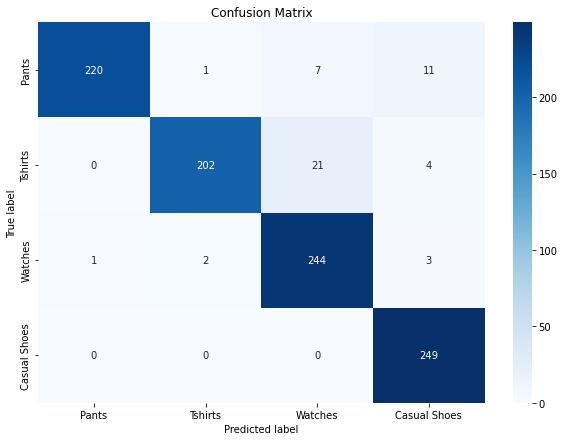

In [35]:

# Create a heatmap
# Create a list of labels
labels = [decipher_key[i] for i in range(4)]
plt.figure(figsize=(10,7))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

**pull misclassified examples**

In [36]:
misclassified_indexes = []

for i in range(len(y_test_u)):
    # If true label is 'Tshirts' (which corresponds to 1)
    # and predicted label is 'Casual Shoes' (which corresponds to 3)
    if (y_test_u[i] == 1) and (y_pred_u[i] == 3):
        misclassified_indexes.append(i)

# Now, misclassified_indexes contains the indexes of all misclassified examples





In [37]:
misclassified_indexes

[255, 606, 621, 743]

**Approx 95% is an improvement, but not as good as grayscale on LinearSVC alone. Lets check if K-NN classifier is better**